#### 파이프라인?
```
데이터 전처리, 특성 추출, 모델학습을 하나의 흐름으로 연결
```
#### 사용이유
```
코드 간결화 : 여러단계를 하나로 묶어 관리
재현성 보장 : 전체 프로세스를 일관되게 실행
데이터 누수 방지 : 교차 검증시 각 fold에서 독립적으로 전처리
하이퍼 파라메터 뉴팅 용이 : 전체 파이프라인에 대해서 그리드서치 적용
```

#### 파이프라인 구성요소
```
변환기
    데이터를 변환하는 객체
    fit() : 데이터에서 파라메터를 학습
    transform(): 학습파라메터로 데이터를 변환
    StandardScaler, PCA, MinMaxScaler...
추정기
    머신러닝 모델
    fit() : 데이터로 모델을 학습
    predict() : 예측 수행
    RandomaForest, SVM...
```
#### 데이터: 위스콘시 유방암 데이터 대표적인 이진분류 데이터
```
클래스 2(양성 악성)
특성: 10개
```

In [18]:
# 파이프라인 구성
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('pca',PCA(n_components=2)),
    ('classifier',LogisticRegression())
]) #장점 일괄되게 

#### 파이프라인 실행과정
```
pipe.fit(X_train,y_train)
Standardscaler x_train에 fit -->평균과 표준편차 계산
x_train 을 표준화 x_scaled
PCA가 x_scaled fit -> 주성분 계산
x_scaled 변환 x_pca
LogisticRegression이 x_pca fit #데이터누수 방지
```

#### 데이터 누수 방지
```
잘못된 예
전체 데이터를 먼저 스케일링
X_scaled = scaler.fit_transform(x)
X_train , X_test = train_test_split(X_scaled)
model.fit(X_train, y_train)
```
문제--> 테스트 데이터 정보가 스케일에 사용
```
올바른 예
학습데이터만으로 스케일링
x_train, X_test = train_test.spilit(X)
X_train_scaled = scaler.fit_transfotm(X_train)
X_test_scaled = scaler.transform(X_test) #fit 없이 transform만 !!!
model.fit(X_train_scaled, y_train)
```

#### 파이프라인 사용(best)
```
pipe.fit(X_train, y_train) #학습데이터만 fit
pipe.predict(X_test) #테스트데이터는 transform만 적용
```

#### 교차검증... k-겹
```
홀드아웃 : 데이터를 학습세트 테스트 세트 한번만 분할
전체데이터 100%
    학습 70~80
    테스트 20~30
장점:
    빠르다
    대용량 데이터에 적합
단점:
    데이터 분할에 따라서 성능이 크게 달라질 수 있음
    작은 데이터셋 불안
    일부 데이터만 학습에 사용
언제사용:
    데이터가 충분히 많을 때(수만개 이상)
    빠르게 평가할때
```

```
k-겹 교차검증(k-fold Cross-Validation)
```
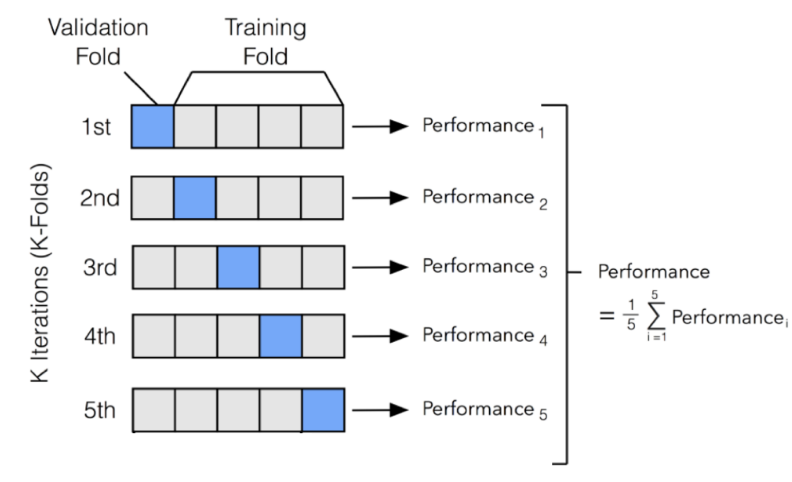

#### k-fold
```
일반k-fold
층화 stratified k-fold
```

#### 학습곡선과 검증 곡선
```
학습 데이터 크기에 따른 모델 성능을 시각화
```

#### 그리드 서치를 사용한 머신러닝 모델 세부 튜닝
```
하이퍼파라메터
    파라메터: 학습으로 찾음
        선형회귀 계수, 신경망의 가중치
        ...
    하이퍼 파라메터: 사람이 설정
        학습율
        정규화
        트리의 깊이
        ....
그리드서치: 모든 가능한 조합으로 체계적으로 시도
param_grid ={
    'max_depth' :[3,5,],
    ...
}
랜덤그리드서치: 모든 가능한 조합을 랜덤하게
    더 넓은 영역을 탐색-> 파라메터의 조합의 경우의 수
    시간제약이 있을때
언제 사용
    그리드서치 : 하이퍼 파라메터 :2~3
    랜덤그리드서치: 하이퍼 파라메터: 4개이상
그리드 서치(각 3개의 값)
A: 3개의 고유값
B: 3개의 고유값
랜덤서치(9번시도)
서로 다른 최대 9개의 값으로 시도
중요한 파라메터에 더 많은 시도
CONFUSION MATRIC 분류모델에서 오차행렬
```

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import(
    train_test_split,cross_val_score, StratifiedKFold,
    learning_curve, validation_curve, GridSearchCV, RandomizedSearchCV,
    cross_validate
)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import randint, uniform
import warnings 
warnings.filterwarnings('ignore')

In [20]:
# SECTION 1 위스콘신 유방망 데이터셋 로드 및 탐색
def section1_load_data():
    """
        데이터셋 구조 이해
        특성과 타겟의 관계 파악
        클래스 분포 확인
    """
    print("section 1 : 위스콘신 유방암 데이터셋")
    #데이터 로드
    data = load_breast_cancer()
    X,y = data.data, data.target #sklearn제공 data와 target으로 제공
    print("데이터셋 기본정보")
    print(f'샘플 수 :{X.shape[0]}')
    print(f'특성 수 :{X.shape[1]}')
    print(f'클래스 :{data.target_names}')
    #클래스 분포
    # np.unique(y) # np.unique unique한 값 찾아주는거
    unique,counts = np.unique(y,return_counts = True)
    print("클래스분포")
    zip(unique, counts)
    for label, count in zip(unique,counts):
        class_name = data.target_names[label]
        percentage = count / len(y) *100
        print(f'{class_name} : {count}개 ({percentage:1f}%)')
    #특성 통계
    print("특성통계 (처음 5개 특성)")

    for i in range(5):
        print(f'{data.feature_names[i]}:')
        print(f'평균: {X[:,i].mean():.2f}')
        print(f'표준편차: {X[:,i].std():.2f}')
        print(f'최소값:{X[:,i].min():.2f}')
        print(f'최대값:{X[:,i].max():.2f}')
    return X, y, data

In [21]:
# section 1  : 위스콘신 유방망 데이터셋 로드 및 탐색
def section1_load_data():
    """
        데이터셋 구조 이해
        특성과 타겟의 관계 파악
        클래스 분포 확인
    """
    print("section 1 : 위스콘신 유방암 데이터셋")

    # 데이터 로드
    data = load_breast_cancer()
    X, y = data.data, data.target
    print("데이터셋 기본정보")
    print(f'샘플 수 : { X.shape[0] }')
    print(f'특성 수 : { X.shape[1] }')
    print(f'클래스 : {data.target_names}')
    # 클래스 분포
    unique, counts =  np.unique(y,return_counts=True)
    print("클래스분포")
    for label, count in zip(unique, counts):
        class_name = data.target_names[label]
        percentage = count / len(y) * 100
        print(f' {class_name} : {count}개 ({percentage:.1f}%)')
    # 특성 통계
    print("특성 통계 (처음 5개 특성)")
    df_lists = []
    for i in range(5):
        index_name = data.feature_names[i]
        stats = {
                'mean': X[:,i].mean(),
                    'std':X[:,i].std(),
                    'min':X[:,i].min(),
                    'max':X[:,i].max()
        }    
        df_lists.append(pd.DataFrame(stats,index = [index_name]))
    print(pd.concat(df_lists))
    return X, y, data

In [22]:
X,y,data = section1_load_data()

section 1 : 위스콘신 유방암 데이터셋
데이터셋 기본정보
샘플 수 : 569
특성 수 : 30
클래스 : ['malignant' 'benign']
클래스분포
 malignant : 212개 (37.3%)
 benign : 357개 (62.7%)
특성 통계 (처음 5개 특성)
                       mean         std        min        max
mean radius       14.127292    3.520951    6.98100    28.1100
mean texture      19.289649    4.297255    9.71000    39.2800
mean perimeter    91.969033   24.277619   43.79000   188.5000
mean area        654.889104  351.604754  143.50000  2501.0000
mean smoothness    0.096360    0.014052    0.05263     0.1634


In [23]:
# sescssion 2 파이프라인 기본 사용법

In [24]:
def section2_basic_pipeline(X,y):
    """
    - Pipeline 객체생성
    - 표준화 +  모델학습을 한번에 수행
    - 파이프라인의 장점을 이해
    """

#데이터 분할
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3, random_state=42, stratify=y)
#수동방식
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
lr = LogisticRegression(random_state=42, max_iter=1000) #max_iter 학습횟수 지정
lr.fit(X_train_scaled,y_train)
manual_score = lr.score(X_test_scaled,y_test)
print(f'학습세트 크기: {X_train.shape[0]}')
print(f'테스트세트 크기: {X_test.shape[0]}')
print(f'테스트 정확도:{manual_score:.4f}')

print('파이프라인', '*'*100)
pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('clssfier',LogisticRegression(random_state=42,max_iter=1000))
])
pipe.fit(X_train,y_train) #파이프라인 아무것도 안하려고 모델링학습 같이 하는거라 굳이 스케일링 한값 안해도 됌
pipeline_score = pipe.score(X_test,y_test)
print(f'파이프라인 구조')
for name, step in pipe.steps:
    print(f'{name}: {step.__class__.__name__}')

print(f"테스트 정확도 : {pipeline_score:.4f}")
print(f'수동방식과 동일한 결과: {np.isclose(manual_score,pipeline_score)}')

학습세트 크기: 398
테스트세트 크기: 171
테스트 정확도:0.9883
파이프라인 ****************************************************************************************************
파이프라인 구조
scaler: StandardScaler
clssfier: LogisticRegression
테스트 정확도 : 0.9883
수동방식과 동일한 결과: True


In [25]:
section2_basic_pipeline

<function __main__.section2_basic_pipeline(X, y)>

In [26]:
#교차 검증 비교(홀드아웃 vs k-겹)
def section3_validation(X,y):
    """
    - 홀드아웃의 한계
    - k-겹 교차검증의 장점
    - 층화 k-겹의 중요성
    """
pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('classfier',LogisticRegression(random_state=42,max_iter=1000))
])
#여러번 반복해서 불안정성 확인
holdout_scores = []
for i in range(10):
    X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3, random_state=i, stratify=y)
    pipe.fit(X_train,y_train)
    holdout_score = pipe.score(X_test,y_test)
    holdout_scores.append(holdout_score)
    #처음 3개만 출력
    if i <3:
        print(f' {i+1}: {holdout_score:.4f}')
print('---')
print(f'홀드아웃 평균: {np.mean(holdout_scores):.4f} 표준편차 :{np.std(holdout_scores):4f}')
print(f'min: {np.min(holdout_scores)} max:{np.max(holdout_scores)}')

#5-겹 교차 검증
cv_scores = cross_val_score(pipe,X,y,cv=5,scoring = 'accuracy')
print('각 Fold의 점수')
for i , score in enumerate(cv_scores,1):
    print(f' fold {i} : {score:.4f}')
print(f'교차검증 평균 : {np.mean(cv_scores):.4f} 표준편차: {np.std(cv_scores):.4f}')

print('-'*100)
# 층화 k 겹
skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=42)
stratified_scores = cross_val_score(pipe,X,y,cv=skf,scoring = 'accuracy')
for i , score in enumerate(stratified_scores,1):
    print(f' fold {i} : {score:.4f}')
print(f'층화 교차검증 평균 : {np.mean(stratified_scores):.4f} 표준편차: {np.std(stratified_scores):.4f}')

#각 fold의 클래스 분포 확인
for i, (train_index, test_index) in enumerate(skf.split(X,y),1):
    y_fold = y[test_index]
    unique, counts = np.unique(y_fold, return_counts=True)
    ratio = counts[1] / len(y_fold)*100
    print(f'fold {i} : 악성{ratio:.1f}%')

print("결론")
print(f'홀드아웃: 분할에 따라 성능차이가 큼 : {np.std(holdout_scores):.4f}')
print(f'k-겹: 더 안정적인 추정: {np.std(cv_scores):.4f}')
print(f'층화 k-겹:클래스 비율유지로 더 신뢰성 있음 ')

 1: 0.9591
 2: 0.9591
 3: 0.9649
---
홀드아웃 평균: 0.9719 표준편차 :0.010061
min: 0.9590643274853801 max:0.9883040935672515
각 Fold의 점수
 fold 1 : 0.9825
 fold 2 : 0.9825
 fold 3 : 0.9737
 fold 4 : 0.9737
 fold 5 : 0.9912
교차검증 평균 : 0.9807 표준편차: 0.0065
----------------------------------------------------------------------------------------------------
 fold 1 : 0.9737
 fold 2 : 0.9474
 fold 3 : 0.9649
 fold 4 : 0.9912
 fold 5 : 0.9912
층화 교차검증 평균 : 0.9737 표준편차: 0.0166
fold 1 : 악성62.3%
fold 2 : 악성62.3%
fold 3 : 악성63.2%
fold 4 : 악성63.2%
fold 5 : 악성62.8%
결론
홀드아웃: 분할에 따라 성능차이가 큼 : 0.0101
k-겹: 더 안정적인 추정: 0.0065
층화 k-겹:클래스 비율유지로 더 신뢰성 있음 


In [27]:
# 섹션 4 : 학습곡선으로 편향-분산 분석
def section4_learning_curves(X,y):
    """
    - 학습곡선
    - 과소적합 / 과대적합 판단
    - 데이터 추가 필요성 판단
    """
    print('다양한 모델의 학습곡선 비교')
    models = [
        ('underfit\n(simple model)', 
         Pipeline([('sacler',StandardScaler()),('clf',LogisticRegression(C=0.01,max_iter = 1000))]) ),  # C는 규제강도

        ('normal\n(basic model)', 
         Pipeline([('sacler',StandardScaler()),('clf',LogisticRegression(C=1.0,max_iter = 1000))]) ),

        ('small overfit \n(complex model)', 
         Pipeline([('sacler',StandardScaler()),('clf',SVC(kernel='rbf',gamma='auto'))]) ),

        ('overfit\n(strong complex model)', 
         Pipeline([('sacler',StandardScaler()),('clf',DecisionTreeClassifier())]) ),
    ]
    fig, axes = plt.subplots(2,2,figsize=(15,12))

    for idx, (title, model) in enumerate(models):
        ax = axes[idx // 2, idx % 2] # (0, 0) (0, 1) (1, 0) (1, 1)
        # 학습곡선 계산
        train_sizes,train_score,test_score =          learning_curve(
            model,X,y,cv=5,
            train_sizes=np.linspace(0.1,1.0,10),
            scoring='accuracy',
            n_jobs=-1
        )
        # 평균과 표준편차
        train_mean = train_score.mean(axis=1)
        train_std =  train_score.std(axis=1)
        test_mean = test_score.mean(axis=1)
        test_std = test_score.std(axis=1)

        # 그래프 그리기
        ax.plot(train_sizes,train_mean, label='train score', marker='o', color='blue')
        ax.fill_between(train_sizes, train_mean - train_std, train_mean+train_std, alpha=0.15, color='blue')

        ax.plot(train_sizes,test_mean, label='test score', marker='s', color='red')
        ax.fill_between(train_sizes, test_mean - test_std, test_mean+test_std, alpha=0.15, color='red')

        ax.set_xlabel('train sample counts', fontsize=10)
        ax.set_ylabel('accuracy', fontsize=10)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0.5,1.05])

        # 최종성능 출력
        final_train = train_mean[-1]
        final_test = test_mean[-1]
        gap = final_train - final_test

        print(f' 최종 학습점수 : {final_train}')
        print(f' 최종 검증점수 : {final_test}')
        print(f' 점수차이 : {gap}')

        if gap < 0.05 and final_test < 0.85:
            print(' 진단 : 과소적합(높은 편향)')
            print(' 해결책 : 더 복잡한 모델 사용')
        elif gap > 0.15:
            print(' 진단 : 과대적합(높은 분산)')
            print(' 해결책 : 더 많은 데이터 수집 또는 정규화 증가')
        else:
            print(' 진단 : 적절한 적합')

다양한 모델의 학습곡선 비교
 최종 학습점수 : 0.9556043956043956
 최종 검증점수 : 0.9490607048594939
 점수차이 : 0.006543690744901687
 진단 : 적절한 적합
 최종 학습점수 : 0.9894505494505494
 최종 검증점수 : 0.9806862288464524
 점수차이 : 0.008764320604097042
 진단 : 적절한 적합
 최종 학습점수 : 0.9872527472527473
 최종 검증점수 : 0.9736376339077782
 점수차이 : 0.01361511334496901
 진단 : 적절한 적합
 최종 학습점수 : 1.0
 최종 검증점수 : 0.9191274646793977
 점수차이 : 0.08087253532060235
 진단 : 적절한 적합


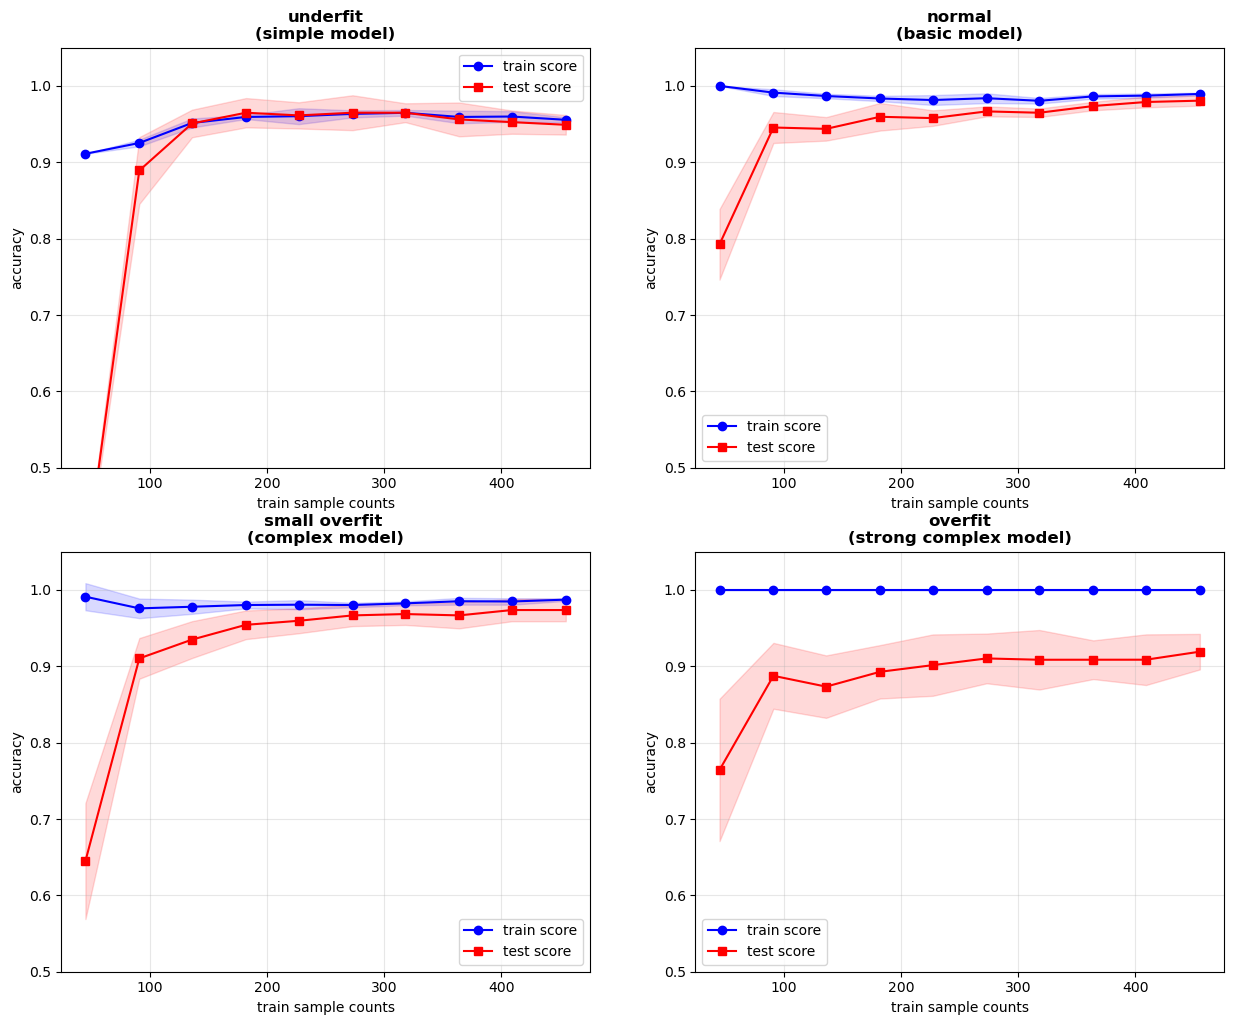

In [28]:
section4_learning_curves(X,y)


In [29]:
# 검증곡선으로 하이퍼 파라메터 분석
def section5_validation_curve(X, y):
    """
    - 검증곡선
    - 최적 화이퍼파라메터 범위 확인
    - 과대/과소 적합 구간 확인
    """
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    # Logistic Regression C 파라메터
    print(f'Logistic Regression 정규화 파라메터 C')
    print(f' ( C 가 적을수록 강한 정규화 )')

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000))
    ])
    param_range = np.logspace(-4,4,9)  # 0.0001 ~ 10000
    train_scores, test_scores =  validation_curve(
        pipe,X,y,
        param_name='clf__C',
        param_range= param_range,
        cv=5,
        scoring='accuracy'  ,
        n_jobs = -1
    )
    # 평균과 표준편차
    train_mean = train_scores.mean(axis=1)
    train_std =  train_scores.std(axis=1)
    test_mean = test_scores.mean(axis=1)
    test_std = test_scores.std(axis=1)

    # 그래프 그리기  semilogx x축을 로그 스케일로 설정해서 선 을 그리는 함수  작은값부터 큰 값까지 폭 넒게 분포된 값을 시각화
    ax[0].semilogx(param_range,train_mean, label='train score', marker='o', color='blue')
    ax[0].fill_between(param_range, train_mean - train_std, train_mean+train_std, alpha=0.15, color='blue')

    ax[0].semilogx(param_range,test_mean, label='test score', marker='s', color='red')
    ax[0].fill_between(param_range, test_mean - test_std, test_mean+test_std, alpha=0.15, color='red')

    ax[0].set_xlabel('Parameter C', fontsize=10)
    ax[0].set_ylabel('accuracy', fontsize=10)
    ax[0].set_title("logistic regression C ", fontsize=12, fontweight='bold')
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)  

    # 최적의 값
    best_idx = np.argmax(test_mean)  
    best_c = param_range[best_idx]
    best_score = test_mean[best_idx]

    print(f'최적의 C : {best_c:.4f}')
    print(f'최고 검증 점수는 : {best_score:.4f}')

    # Decision Tree max_depth 파라메터

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', DecisionTreeClassifier())
    ])
    param_range = range(1,21)
    train_scores, test_scores =  validation_curve(
        pipe,X,y,
        param_name='clf__max_depth',
        param_range= param_range,
        cv=5,
        scoring='accuracy'  ,
        n_jobs = -1
    )
    # 평균과 표준편차
    train_mean = train_scores.mean(axis=1)
    train_std =  train_scores.std(axis=1)
    test_mean = test_scores.mean(axis=1)
    test_std = test_scores.std(axis=1)

    # 그래프 그리기  semilogx x축을 로그 스케일로 설정해서 선 을 그리는 함수  작은값부터 큰 값까지 폭 넒게 분포된 값을 시각화
    ax[1].semilogx(param_range,train_mean, label='train score', marker='o', color='blue')
    ax[1].fill_between(param_range, train_mean - train_std, train_mean+train_std, alpha=0.15, color='blue')

    ax[1].semilogx(param_range,test_mean, label='test score', marker='s', color='red')
    ax[1].fill_between(param_range, test_mean - test_std, test_mean+test_std, alpha=0.15, color='red')

    ax[1].set_xlabel('Parameter max_depth', fontsize=10)
    ax[1].set_ylabel('accuracy', fontsize=10)
    ax[1].set_title("logistic regression max_depth ", fontsize=12, fontweight='bold')
    ax[1].legend()
    ax[1].grid(True, alpha=0.3)  

    # 최적의 값
    best_idx = np.argmax(test_mean)  
    best_c = param_range[best_idx]
    best_score = test_mean[best_idx]

    print(f'최적의 max_depth : {best_c:.4f}')
    print(f'최고 검증 점수는 : {best_score:.4f}')

    


Logistic Regression 정규화 파라메터 C
 ( C 가 적을수록 강한 정규화 )
최적의 C : 1.0000
최고 검증 점수는 : 0.9807
최적의 max_depth : 2.0000
최고 검증 점수는 : 0.9280


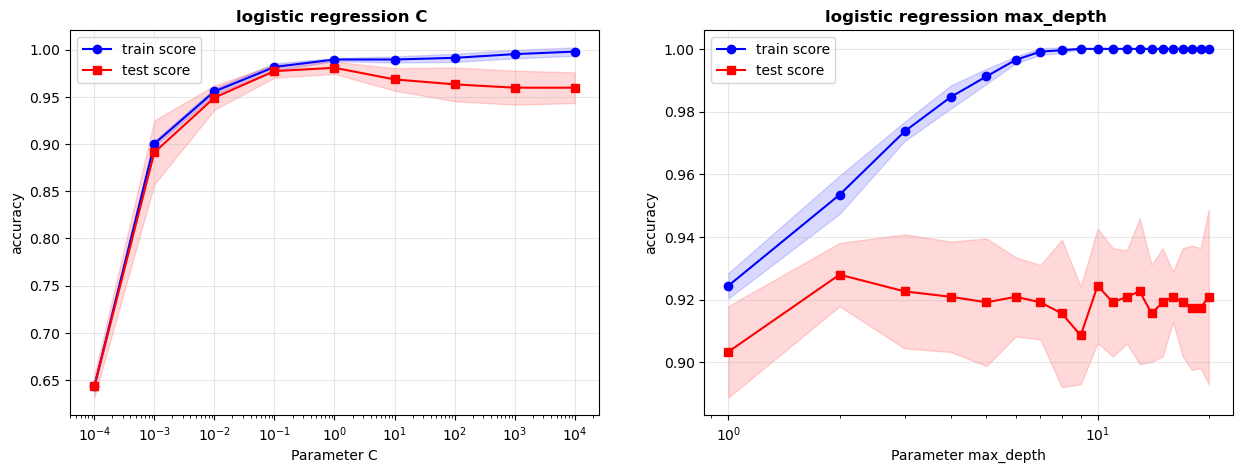

In [30]:
section5_validation_curve(X,y)
